In [18]:
import os
from pathlib import Path
import pandas as pd

import trompy as tp

%run "..//src//vgp_helper_fx"
%run "..//src//plots_for_spectral"

In [2]:
ROOT_FOLDER = Path("D:\\TestData\\2photon")

DATA_FOLDER = ROOT_FOLDER / "VGP_procd_data_22-12-05"
BEHAV_FOLDER = ROOT_FOLDER / "bonsai" / "behav"
METAFILE = DATA_FOLDER / "metafile_vgp.csv"


In [3]:
metafile = pd.read_csv(METAFILE)

In [4]:
len(metafile)

440

In [5]:
metafile.columns

Index(['animal', 'date', 'day', 'phase', 'solution', 'eventfile', 'framefile',
       'licks', 'scanimagefile', 'folder', 'diet', 'session', 'Ses',
       'Unnamed: 13', 'Unnamed: 14'],
      dtype='object')

In [23]:


def convert_date(date_string):
    
    d,m,y = date_string.split("/")
    
    return ("").join([y,m,d])


def make_licks_df(row):
    
    # key=row[0]+'_'+row[1]
    animal=row.animal.item()
    day=str(row.day.item()).zfill(3)
    date_from_metafile=str(row.date.item())

    date = convert_date(date_from_metafile)
    
    s2p_folder = DATA_FOLDER / f"sub-{animal}" / f"ses-{day}-{date}" / "suite2p" / "plane0"
    events_file = BEHAV_FOLDER / f"sub-{animal}" / f"ses-{day}-{date}" / f"sub-{animal}_ses-{day}_events.csv"
    
    print(s2p_folder)
    
    d = assemble_data(s2p_folder,events_file)
    
    return d["lick_snips_all"]

row = metafile.query("animal == 'VGP118' and solution == 'Cas' and session == 'S2' and diet == 'PR'")

print(len(row))

d = make_licks_df(row)

1
D:\TestData\2photon\VGP_procd_data_22-12-05\sub-VGP118\ses-025-20221006\suite2p\plane0


In [155]:
# make dataframe of cells for Casein day (S2)

mice = metafile.animal.unique()
solution = "Cas"
diet = "PR"
session ="S2"

dfs = []

for mouse in mice:
    animal_data = metafile.query("animal == @mouse")
    row = metafile.query("animal == @mouse and solution == @solution and diet == @diet and session == @session")
    if len(row) > 0: # tests if there is any data in row, if there is not probably because NR mouse
        dfs.append(make_licks_df(row))
    ## include the lines below to include both diet groups
    row = metafile.query("animal == @mouse and solution == @solution and diet == 'NR' and session == @session")
    if len(row) > 0: # tests if there is any data in row, if there is not probably because NR mouse
        dfs.append(make_licks_df(row))
    
cell_averages = []
for df in dfs:
    tmp = np.mean(df, axis=1)
    cell_averages.append(tmp)
    print(tmp.shape)
    
all_cells = np.concatenate(cell_averages)

print(f"There are a total number of {all_cells.shape[0]} cells")

D:\TestData\2photon\VGP_procd_data_22-12-05\sub-VGP118\ses-025-20221006\suite2p\plane0
D:\TestData\2photon\VGP_procd_data_22-12-05\sub-VGP202\ses-025-20221006\suite2p\plane0
D:\TestData\2photon\VGP_procd_data_22-12-05\sub-VGP203\ses-029-20221010\suite2p\plane0
D:\TestData\2photon\VGP_procd_data_22-12-05\sub-VGP204\ses-029-20221010\suite2p\plane0
D:\TestData\2photon\VGP_procd_data_22-12-05\sub-VGP302\ses-038-20221118\suite2p\plane0
D:\TestData\2photon\VGP_procd_data_22-12-05\sub-VGP306\ses-038-20221118\suite2p\plane0
D:\TestData\2photon\VGP_procd_data_22-12-05\sub-VGP307\ses-038-20221118\suite2p\plane0
D:\TestData\2photon\VGP_procd_data_22-12-05\sub-VGP310\ses-038-20221118\suite2p\plane0
D:\TestData\2photon\VGP_procd_data_22-12-05\sub-VGP402\ses-030-20230320\suite2p\plane0
D:\TestData\2photon\VGP_procd_data_22-12-05\sub-VGP403\ses-030-20230320\suite2p\plane0
D:\TestData\2photon\VGP_procd_data_22-12-05\sub-VGP404\ses-030-20230320\suite2p\plane0
D:\TestData\2photon\VGP_procd_data_22-12-05

In [156]:
populationdata = all_cells

In [157]:
framerate = 10
pre_window_size = 5*framerate # 3 seconds multipled by 5 frames. Corresponds to baseline prior to cues.
window_size = 150 # Total number of frames plotted around a cue
frames_to_reward = 5*framerate # 3 seconds until reward after CS+

sortwindow = [pre_window_size, pre_window_size + frames_to_reward] # Sort responses between CS+ onset and reward.
sortresponse = np.argsort(np.mean(populationdata[:,sortwindow[0]:sortwindow[1]], axis=1))[::-1]
# sortresponse corresponds to an ordering of the neurons based on their average response in the sortwindow

cmax = 0.1 # Maximum colormap value. 

trial_types = ['cas']

C:\Users\jmc010\AppData\Local\Temp\ipykernel_15480\795295410.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


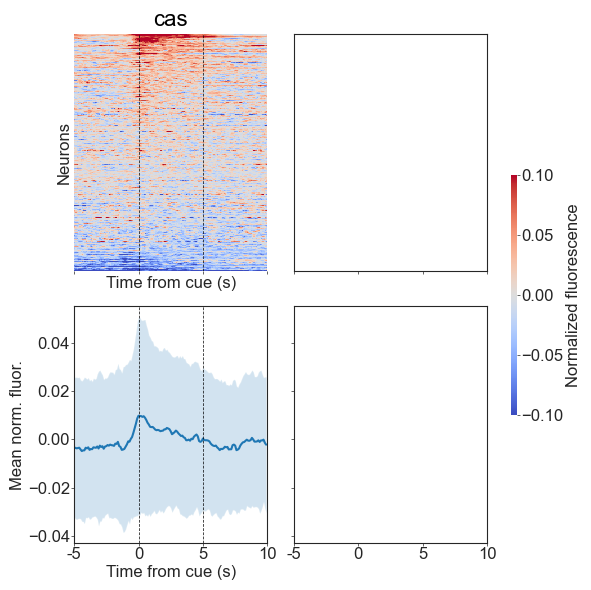

In [158]:
fig, axs = plt.subplots(2,2,figsize=(3*2,3*2), sharex='all', sharey='row')
cbar_ax = fig.add_axes([0.86, .3, .01, .4])
cbar_ax.tick_params(width=0.5) 

for t in range(len(trial_types)):
    axs[0,t].set_title(trial_types[t])
    ax = axs[0,t]
    sns.heatmap(populationdata[sortresponse, t*window_size: (t+1)*window_size],
                ax=ax,
                cmap=plt.get_cmap('coolwarm'),
                vmin=-cmax,
                vmax=cmax,
                cbar=(t==0),
                cbar_ax=cbar_ax if (t==0) else None,
                cbar_kws={'label': 'Normalized fluorescence'})
    ax.grid(False)
    ax.tick_params(width=0.5)   
    ax.set_xticks([0, pre_window_size, pre_window_size + frames_to_reward, window_size]) 
    ax.set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                                     for a in [0, pre_window_size,
                                               pre_window_size + frames_to_reward, window_size]])
    ax.set_yticks([])
    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)    
    ax.axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)    
    ax.set_xlabel('Time from cue (s)')
    
        
    ax = axs[1,t]
    tsplot(ax, populationdata[sortresponse, t*window_size:(t+1)*window_size],
              )
    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)    
    ax.axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)    
    ax.set_xlabel('Time from cue (s)')
    ax.set_xticks([0, pre_window_size, pre_window_size + frames_to_reward, window_size]) 
    ax.set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                                     for a in [0, pre_window_size,
                                               pre_window_size + frames_to_reward, window_size]])
    
axs[0,0].set_ylabel('Neurons')
axs[1,0].set_ylabel('Mean norm. fluor.')

fig.tight_layout()
fig.subplots_adjust(right=0.82)

Number of PCs = 150
Number of PCs to keep = 4
cas
cas
cas
cas


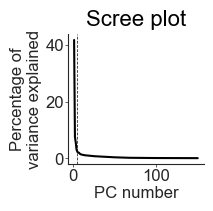

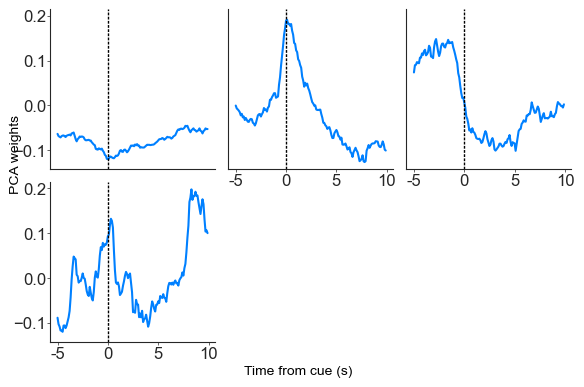

In [159]:
load_savedpca_or_dopca = 'dopca'
# Select 'dopca' for doing PCA on the data. Select 'savedpca' for loading my previous results

if load_savedpca_or_dopca == 'dopca':
    pca = PCA(n_components=populationdata.shape[1], whiten=True)
    pca.fit(populationdata) 
    with open(os.path.join(ROOT_FOLDER, 'pcaresults.pickle'), 'wb') as f:
        pickle.dump(pca, f)
elif load_savedpca_or_dopca == 'savedpca':
    with open(os.path.join(ROOT_FOLDER, 'OFCCaMKII_pcaresults.pickle'), 'rb') as f:
        pca = pickle.load(f)
    
transformed_data = pca.transform(populationdata)
with open(os.path.join(ROOT_FOLDER, 'cas_transformed_data.pickle'), 'wb') as f:
        pickle.dump(transformed_data, f)

pca_vectors = pca.components_
print('Number of PCs = %d'%(pca_vectors.shape[0]))

x = 100*pca.explained_variance_ratio_
xprime = x - (x[0] + (x[-1]-x[0])/(x.size-1)*np.arange(x.size))
num_retained_pcs = np.argmin(xprime)
# Number of PCs to be kept is defined as the number at which the 
# scree plot bends. This is done by simply bending the scree plot
# around the line joining (1, variance explained by first PC) and
# (num of PCs, variance explained by the last PC) and finding the 
# number of components just below the minimum of this rotated plot
print('Number of PCs to keep = %d'%(num_retained_pcs))

fig, ax = plt.subplots(figsize=(2,2))
ax.plot(np.arange(pca.explained_variance_ratio_.shape[0]).astype(int)+1, x, 'k')
ax.set_ylabel('Percentage of\nvariance explained')
ax.set_xlabel('PC number')
ax.axvline(num_retained_pcs, linestyle='--', color='k', linewidth=0.5)
ax.set_title('Scree plot')
# ax.set_xlim([0,50])
#[i.set_linewidth(0.5) for i in ax.spines.itervalues()]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.subplots_adjust(left=0.3)
fig.subplots_adjust(right=0.98)
fig.subplots_adjust(bottom=0.25)
fig.subplots_adjust(top=0.9)

colors_for_key = {}
colors_for_key['cas'] = (0,0.5,1)
colors_for_key['CS-'] = (1,0.5,0)

numcols = 3.0
fig, axs = plt.subplots(int(np.ceil(num_retained_pcs/numcols)), int(numcols), sharey='all',
                        figsize=(2*numcols, 2*int(np.ceil(num_retained_pcs/numcols))))
for pc in range(num_retained_pcs):
    ax = axs.flat[pc]
    for k, tempkey in enumerate(trial_types):
        print(tempkey)
        ax.plot(pca_vectors[pc, k*window_size:(k+1)*window_size], color=colors_for_key[tempkey],
                label='PC %d: %s'%(pc+1, tempkey))
    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=1)
    # ax.annotate(s='PC %d'%(pc+1), xy=(0.45, 0.06), xytext=(0.45, 0.06), xycoords='axes fraction',
    #            textcoords='axes fraction', multialignment='center', size='large')
    if pc >= num_retained_pcs-numcols:
        ax.set_xticks([0, pre_window_size,
                       pre_window_size + frames_to_reward, window_size])
        ax.set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                             for a in [0, pre_window_size,
                                       pre_window_size + frames_to_reward, window_size]])
    else:
        ax.set_xticks([])
        ax.xaxis.set_ticks_position('none')
    if pc%numcols:
        ax.yaxis.set_ticks_position('none')
    # [i.set_linewidth(0.5) for i in ax.spines.itervalues()]
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)


fig.text(0.5, 0.05, 'Time from cue (s)', horizontalalignment='center', rotation='horizontal')
fig.text(0.02, 0.6, 'PCA weights', verticalalignment='center', rotation='vertical')
fig.tight_layout()
for ax in axs.flat[num_retained_pcs:]:
    ax.set_visible(False)

fig.subplots_adjust(wspace=0.08, hspace=0.08)
fig.subplots_adjust(bottom=0.13)

In [160]:
trial_types

['cas']

In [161]:
transformed_data

array([[ 1.64122248,  2.22189825,  2.27631944, ..., -1.25371697,
         0.53790203, -0.0104931 ],
       [ 0.51833041,  1.30296299,  1.13023162, ..., -0.39900562,
        -0.80357822, -2.15237541],
       [ 0.9704607 ,  1.37249766, -0.0054232 , ...,  0.95706554,
         0.55976485, -0.36451725],
       ...,
       [ 0.05687861, -0.88953044, -0.04686169, ...,  0.79143559,
         0.94610947,  2.10567648],
       [-0.40748791,  0.92086752,  0.34852743, ...,  0.22152519,
        -2.19510135,  1.27721866],
       [-1.33954901,  0.39932   ,  0.42920279, ..., -1.00977712,
        -0.23341778, -0.59276959]])

In [162]:
max_n_clusters = 9 # Maximum number of clusters expected. I already ran this with up to 20 clusters and know
# that the optimal number is 9. So, I am leaving this at 11. In your data, might be worth increasing this, but
# it will take more time to run.

possible_n_clusters = np.arange(2, max_n_clusters+1) #This requires a minimum of 2 clusters.
# When the data contain no clusters at all, it will be quite visible when inspecting the two obtained clusters, 
# as the responses of the clusters will be quite similar. This will also be visible when plotting the data in
# the reduced dimensionality PC space (done below).


possible_n_nearest_neighbors = np.array([10, 20, 50, 100, 200]) # This should be selected for each dataset
# appropriately. When 4813 neurons are present, the above number of nearest neighbors provides a good sweep of the
# parameter space. But it will need to be changed for other data.
    
silhouette_scores = np.nan*np.ones((possible_n_clusters.size,
                                    possible_n_nearest_neighbors.size))

for n_clustersidx, n_clusters in enumerate(possible_n_clusters):
    for nnidx, nn in enumerate(possible_n_nearest_neighbors):
        model = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', n_neighbors=nn)
        model.fit(transformed_data[:,:num_retained_pcs])
        silhouette_scores[n_clustersidx, nnidx] = silhouette_score(transformed_data[:,:num_retained_pcs],
                                                                   model.labels_,
                                                                   metric='cosine')
        print('Done with numclusters = %d, num nearest neighbors = %d: score = %.3f'%(n_clusters,
                                                                                      nn,
                                                                                      silhouette_scores[n_clustersidx,                                                                           
                                                                                                        nnidx]))

print('Done with model fitting')

Done with numclusters = 2, num nearest neighbors = 10: score = 0.287
Done with numclusters = 2, num nearest neighbors = 20: score = 0.333
Done with numclusters = 2, num nearest neighbors = 50: score = 0.352
Done with numclusters = 2, num nearest neighbors = 100: score = 0.358
Done with numclusters = 2, num nearest neighbors = 200: score = 0.357
Done with numclusters = 3, num nearest neighbors = 10: score = 0.253
Done with numclusters = 3, num nearest neighbors = 20: score = 0.290
Done with numclusters = 3, num nearest neighbors = 50: score = 0.312
Done with numclusters = 3, num nearest neighbors = 100: score = 0.339
Done with numclusters = 3, num nearest neighbors = 200: score = 0.346
Done with numclusters = 4, num nearest neighbors = 10: score = 0.314
Done with numclusters = 4, num nearest neighbors = 20: score = 0.324
Done with numclusters = 4, num nearest neighbors = 50: score = 0.363
Done with numclusters = 4, num nearest neighbors = 100: score = 0.373
Done with numclusters = 4, nu

In [163]:
temp = {}
temp['possible_n_clusters'] = possible_n_clusters
temp['possible_n_nearest_neighbors'] = possible_n_nearest_neighbors
temp['silhouette_scores'] = silhouette_scores
temp['shape'] = 'cluster_nn'
with open(os.path.join(ROOT_FOLDER, 'silhouette_scores.pickle'), 'wb') as f:
    pickle.dump(temp, f)

In [165]:
with open(os.path.join(ROOT_FOLDER, 'silhouette_scores.pickle'), 'rb') as f:
    silhouette_scores = pickle.load(f)
    
# transformed_data = np.load(os.path.join(ROOT_FOLDER, 'transformed_data.npy'))

# Identify optimal parameters from the above parameter space
temp = np.where(silhouette_scores['silhouette_scores']==np.nanmax(silhouette_scores['silhouette_scores']))
n_clusters = silhouette_scores['possible_n_clusters'][temp[0][0]]
n_nearest_neighbors = silhouette_scores['possible_n_nearest_neighbors'][temp[1][0]]

print (n_clusters, n_nearest_neighbors)

# Redo clustering with these optimal parameters
model = SpectralClustering(n_clusters=n_clusters,
                           affinity='nearest_neighbors',
                           n_neighbors=n_nearest_neighbors)

# model = KMeans(n_clusters=n_clusters)

# model = AgglomerativeClustering(n_clusters=9,
#                                 affinity='l1',
#                                 linkage='average')

model.fit(transformed_data[:,:num_retained_pcs])

temp = silhouette_score(transformed_data[:,:num_retained_pcs], model.labels_, metric='cosine')

print('Number of clusters = %d, average silhouette = %.3f'%(len(set(model.labels_)), temp))

# Save this optimal clustering model.
# with open(os.path.join(basedir, 'clusteringmodel.pickle'), 'wb') as f:
#     pickle.dump(model, f)

          
# Since the clustering labels are arbitrary, I rename the clusters so that the first cluster will have the most
# positive response and the last cluster will have the most negative response.
def reorder_clusters(rawlabels):
    uniquelabels = list(set(rawlabels))
    responses = np.nan*np.ones((len(uniquelabels),))
    for l, label in enumerate(uniquelabels):
        responses[l] = np.mean(populationdata[rawlabels==label, pre_window_size:2*pre_window_size])
    temp = np.argsort(responses).astype(int)[::-1]
    temp = np.array([np.where(temp==a)[0][0] for a in uniquelabels])
    outputlabels = np.array([temp[a] for a in list(np.digitize(rawlabels, uniquelabels)-1)])
    return outputlabels
newlabels = reorder_clusters(model.labels_)

# Create a new variable containing all unique cluster labels
uniquelabels = list(set(newlabels))

np.save(os.path.join(ROOT_FOLDER, 'cas_clusterlabels.npy'), newlabels)

colors_for_cluster = [[0.933, 0.250, 0.211],
                      "green",
                      [0.941, 0.352, 0.156],
                      [0.964, 0.572, 0.117],
                      [0.980, 0.686, 0.250],
                      [0.545, 0.772, 0.247],
                      [0.215, 0.701, 0.290],
                      [0, 0.576, 0.270],
                      [0, 0.650, 0.611],
                      [0.145, 0.662, 0.878]]

5 100
Number of clusters = 5, average silhouette = 0.377


In [166]:
def make_silhouette_plot(X, cluster_labels):
    
    n_clusters = len(set(cluster_labels))
    
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(4, 4)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax.set_xlim([-0.4, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    silhouette_avg = silhouette_score(X, cluster_labels, metric='cosine')

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels, metric='cosine')

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = colors_for_cluster[i]
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.9)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i+1))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

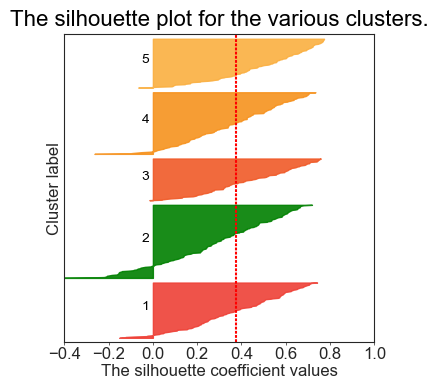

In [167]:
make_silhouette_plot(transformed_data[:,:num_retained_pcs], model.labels_)

C:\Users\jmc010\AppData\Local\Temp\ipykernel_15480\1323678363.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


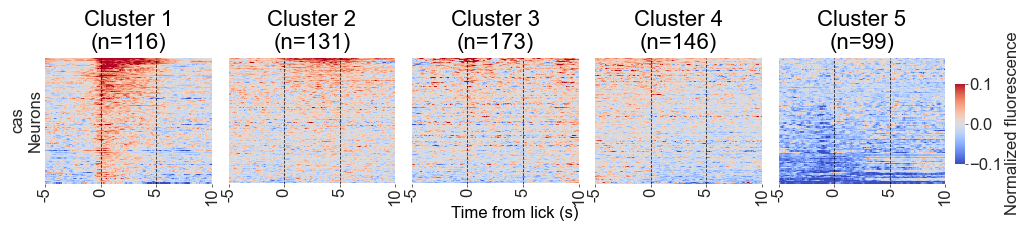

In [168]:
cmax = 0.1
sortwindow = [15, 100]

fig, axs = plt.subplots(len(trial_types),len(uniquelabels),
                        figsize=(2*len(uniquelabels),2*len(trial_types)))
cbar_ax = fig.add_axes([.94, .3, .01, .4])
cbar_ax.tick_params(width=0.5) 

numroisincluster = np.nan*np.ones((len(uniquelabels),))
for c, cluster in enumerate(uniquelabels):
    k=0
    tempkey='cas'
    temp = populationdata[np.where(newlabels==cluster)[0], k*window_size:(k+1)*window_size]
    numroisincluster[c] = temp.shape[0]
    sortresponse = np.argsort(np.mean(temp[:,sortwindow[0]:sortwindow[1]], axis=1))[::-1]
    sns.heatmap(temp[sortresponse],
                ax=axs[cluster],
                cmap=plt.get_cmap('coolwarm'),
                vmin=-cmax,
                vmax=cmax,
                cbar=(cluster==0),
                cbar_ax=cbar_ax if (cluster==0) else None,
                cbar_kws={'label': 'Normalized fluorescence'})
    axs[cluster].grid(False)
    
    if k==len(trial_types)-1:
        axs[cluster].set_xticks([0, pre_window_size,
                                    pre_window_size + frames_to_reward, window_size])
    else:
        axs[cluster].set_xticks([])
    axs[cluster].tick_params(width=0.5)    
    axs[cluster].set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                                     for a in [0, pre_window_size,
                                               pre_window_size + frames_to_reward, window_size]])
    axs[cluster].set_yticks([])
    axs[cluster].axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)
    axs[cluster].axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)
    if cluster==0:
        axs[0].set_ylabel('%s\nNeurons'%(tempkey))
    axs[cluster].set_title('Cluster %d\n(n=%d)'%(cluster+1, numroisincluster[c]))

fig.text(0.5, 0.05, 'Time from lick (s)', fontsize=12,
         horizontalalignment='center', verticalalignment='center', rotation='horizontal')
fig.tight_layout()

fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.subplots_adjust(left=0.03)
fig.subplots_adjust(right=0.93)
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(top=0.83)

(116, 150)
(131, 150)
(173, 150)
(146, 150)
(99, 150)


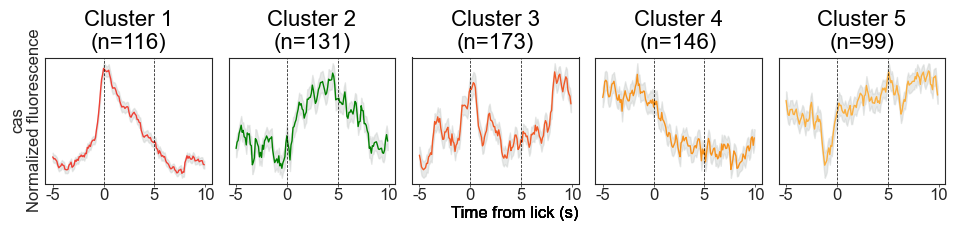

In [143]:
cmax = 0.1
sortwindow = [15, 100]

fig, axs = plt.subplots(len(trial_types),len(uniquelabels),
                        figsize=(2*len(uniquelabels),2*len(trial_types)))

numroisincluster = np.nan*np.ones((len(uniquelabels),))
for c, cluster in enumerate(uniquelabels):
    k=0
    tempkey='cas'
    temp = populationdata[np.where(newlabels==cluster)[0], k*window_size:(k+1)*window_size]
    numroisincluster[c] = temp.shape[0]
    sortresponse = np.argsort(np.mean(temp[:,sortwindow[0]:sortwindow[1]], axis=1))[::-1]
    
    tp.shadedError(axs[cluster], temp, linecolor=colors_for_cluster[c])
    print(temp.shape)
    
    axs[cluster].grid(False)
    
    if k==len(trial_types)-1:
        axs[cluster].set_xticks([0, pre_window_size,
                                    pre_window_size + frames_to_reward, window_size])
    else:
        axs[cluster].set_xticks([])
    axs[cluster].tick_params(width=0.5)    
    axs[cluster].set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                                     for a in [0, pre_window_size,
                                               pre_window_size + frames_to_reward, window_size]])
    
    axs[cluster].set_yticks([])
    axs[cluster].axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)
    axs[cluster].axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)
    if cluster==0:
        axs[0].set_ylabel('%s\nNormalized fluorescence'%(tempkey))
    axs[cluster].set_title('Cluster %d\n(n=%d)'%(cluster+1, numroisincluster[c]))
    
    fig.text(0.5, 0.05, 'Time from lick (s)', fontsize=12,
         horizontalalignment='center', verticalalignment='center', rotation='horizontal')
    fig.tight_layout()

    fig.subplots_adjust(wspace=0.1, hspace=0.1)
    fig.subplots_adjust(left=0.03)
    fig.subplots_adjust(right=0.93)
    fig.subplots_adjust(bottom=0.2)
    fig.subplots_adjust(top=0.83)

C:\Users\jmc010\Miniconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\jmc010\Miniconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\jmc010\Miniconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\jmc010\Miniconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\jmc010\Miniconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\jmc010\Miniconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: Fut

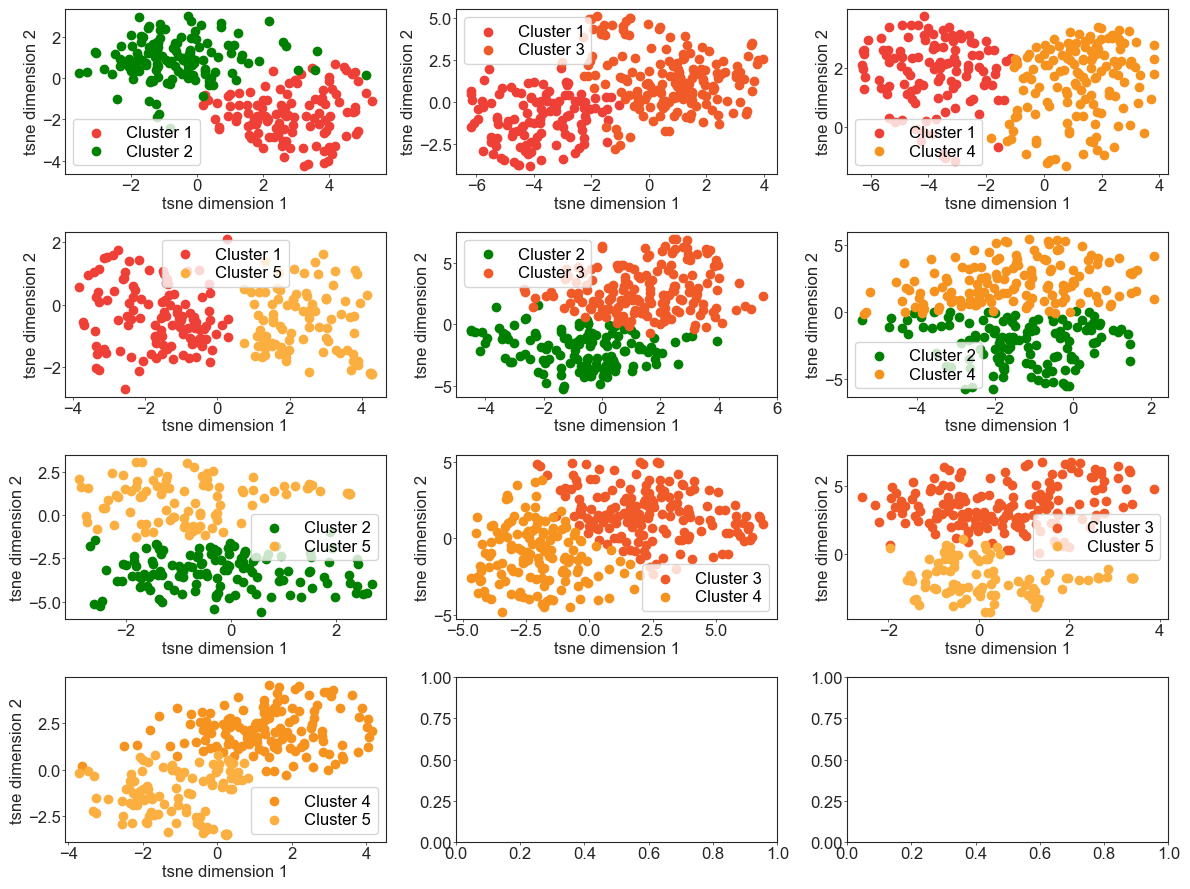

In [144]:
num_clusterpairs = len(uniquelabels)*(len(uniquelabels)-1)/2

numrows = int(np.ceil(num_clusterpairs**0.5))
numcols = int(np.ceil(num_clusterpairs/np.ceil(num_clusterpairs**0.5)))
fig, axs = plt.subplots(numrows, numcols, figsize=(3*numrows, 3*numcols))

tempsum = 0
for c1, cluster1 in enumerate(uniquelabels):
    for c2, cluster2 in enumerate(uniquelabels):
        if cluster1>=cluster2:
            continue
        temp1 = transformed_data[np.where(newlabels==cluster1)[0], :num_retained_pcs]
        temp2 = transformed_data[np.where(newlabels==cluster2)[0], :num_retained_pcs]
        X = np.concatenate((temp1, temp2), axis=0)
        tsne = TSNE(n_components=2, init='random',
                    random_state=0, perplexity=100)
        Y = tsne.fit_transform(X)
        #ax = axs[int(tempsum/numcols),
        #         int(tempsum - tempsum/numcols*numcols)]
        
        try:
            ax = axs.flat[tempsum]
        except:
            ax = axs
        ax.scatter(Y[:np.sum(newlabels==cluster1),0],
                   Y[:np.sum(newlabels==cluster1),1],
                   color=colors_for_cluster[cluster1], label='Cluster %d'%(cluster1+1), alpha=1)
        ax.scatter(Y[np.sum(newlabels==cluster1):,0],
                   Y[np.sum(newlabels==cluster1):,1],
                   color=colors_for_cluster[cluster2], label='Cluster %d'%(cluster2+1), alpha=1)

        ax.set_xlabel('tsne dimension 1')
        ax.set_ylabel('tsne dimension 2')
        ax.legend()
        tempsum += 1
fig.tight_layout()

In [169]:
# make dataframe of cells for Maltodextrin day (S2)

mice = metafile.animal.unique()
solution = "Malt."
diet = "PR"
session ="S2"

dfs = []

for mouse in mice:
    animal_data = metafile.query("animal == @mouse")
    row = metafile.query("animal == @mouse and solution == @solution and diet == @diet and session == @session")
    if len(row) > 0: # tests if there is any data in row, if there is not probably because NR mouse
        dfs.append(make_licks_df(row))
    ## include the lines below to include both diet groups
    row = metafile.query("animal == @mouse and solution == @solution and diet == 'NR' and session == @session")
    if len(row) > 0: # tests if there is any data in row, if there is not probably because NR mouse
        dfs.append(make_licks_df(row))
    
cell_averages = []
for df in dfs:
    tmp = np.mean(df, axis=1)
    cell_averages.append(tmp)
    print(tmp.shape)
    
all_cells = np.concatenate(cell_averages)

print(f"There are a total number of {all_cells.shape[0]} cells")

D:\TestData\2photon\VGP_procd_data_22-12-05\sub-VGP118\ses-029-20221010\suite2p\plane0
D:\TestData\2photon\VGP_procd_data_22-12-05\sub-VGP202\ses-029-20221010\suite2p\plane0
D:\TestData\2photon\VGP_procd_data_22-12-05\sub-VGP203\ses-025-20221006\suite2p\plane0
D:\TestData\2photon\VGP_procd_data_22-12-05\sub-VGP204\ses-032-20221013\suite2p\plane0
D:\TestData\2photon\VGP_procd_data_22-12-05\sub-VGP302\ses-036-20221116\suite2p\plane0
D:\TestData\2photon\VGP_procd_data_22-12-05\sub-VGP306\ses-036-20221116\suite2p\plane0
D:\TestData\2photon\VGP_procd_data_22-12-05\sub-VGP307\ses-036-20221116\suite2p\plane0
D:\TestData\2photon\VGP_procd_data_22-12-05\sub-VGP310\ses-036-20221116\suite2p\plane0
D:\TestData\2photon\VGP_procd_data_22-12-05\sub-VGP402\ses-031-20230321\suite2p\plane0
D:\TestData\2photon\VGP_procd_data_22-12-05\sub-VGP403\ses-031-20230321\suite2p\plane0
D:\TestData\2photon\VGP_procd_data_22-12-05\sub-VGP404\ses-031-20230321\suite2p\plane0
D:\TestData\2photon\VGP_procd_data_22-12-05

Chi2ContingencyResult(statistic=36.214861959311946, pvalue=2.61363503793125e-07, dof=4, expected_freq=array([[100.10408922, 148.6394052 , 203.7472119 , 153.69516729,
         73.81412639],
       [ 97.89591078, 145.3605948 , 199.2527881 , 150.30483271,
         72.18587361]])) 680 665


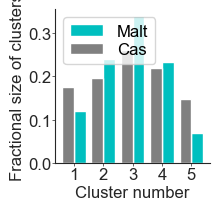

In [174]:
#populationdata = np.load(os.path.join(basedir, 'OFCVTA_populationdata.npy'))

populationdata=all_cells

pca_results_file = os.path.join(ROOT_FOLDER, 'pcaresults.pickle')
reference_file = os.path.join(ROOT_FOLDER, 'cas_transformed_data.pickle')

with open(pca_results_file, 'rb') as f:
    pca = pickle.load(f)
    
with open(reference_file, 'rb') as f:
    reference_data = pickle.load(f)

# Transform malt data into the casein PCA axes
transformed_data = pca.transform(populationdata)

optimal_n_pcs = 4

reference_labels = np.load(os.path.join(ROOT_FOLDER, 'cas_clusterlabels.npy'))

clf = LinearSVC().fit(reference_data[:,:optimal_n_pcs], reference_labels)
predicted_labels = clf.predict(transformed_data[:,:optimal_n_pcs])
uniquelabels = np.sort(np.unique(predicted_labels))


print(stats.chi2_contingency(np.vstack((np.bincount(predicted_labels),
                                        np.bincount(reference_labels)))), predicted_labels.size, reference_labels.size)

fractional_size_predicted = np.bincount(predicted_labels)/(predicted_labels.size+0.0)
fractional_size_reference = np.bincount(reference_labels)/(reference_labels.size+0.0)
# sortorder = np.argsort(fractional_size_reference)[::-1]
sortorder = np.arange(fractional_size_reference.size)

bar_width = 0.4  # default: 0.8
bar_locations = np.arange(uniquelabels.size)

fig, ax = plt.subplots(figsize=(2,2))
ax.bar(bar_locations + bar_width/2, fractional_size_predicted[sortorder], bar_width, color='c', label='Malt')
ax.bar(bar_locations - bar_width/2, fractional_size_reference[sortorder], 
       bar_width, color=[0.5]*3, label='Cas')
ax.set_xticks(np.arange(uniquelabels.size));
ax.set_xticklabels(['%d'%(a+1) for a in uniquelabels[sortorder]]);
ax.set_xlabel('Cluster number')
ax.set_ylabel('Fractional size of clusters')
ax.legend();
# [i.set_linewidth(0.5) for i in ax.spines.itervalues()]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [151]:


bar_width = 0.4  # default: 0.8
bar_locations = np.arange(uniquelabels.size)

fig, ax = plt.subplots(figsize=(2,2))
ax.bar(bar_locations + bar_width/2, fractional_size_predicted[sortorder], bar_width, color='c', label='OFCVTA')
ax.bar(bar_locations - bar_width/2, fractional_size_reference[sortorder], 
       bar_width, color=[0.5]*3, label='CaMKii')
ax.set_xticks(np.arange(uniquelabels.size));
ax.set_xticklabels(['%d'%(a+1) for a in uniquelabels[sortorder]]);
ax.set_xlabel('Cluster number')
ax.set_ylabel('Fractional size of clusters')
ax.legend();
[i.set_linewidth(0.5) for i in ax.spines.itervalues()]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\TestData\\2photon\\cas_transformed_data.npy'